In [6]:
from utils import *
from trimesh import *
from optimal import OptimalSWF
from swf import *
from constants import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [69]:
def Ambisonics_order3_encoding(theta,phi):
    try:
        W = np.ones((theta.shape[0]))
    except:
        W = 1
    Y = np.sqrt(3)*np.sin(theta)*np.cos(phi)
    Z = np.sqrt(3)*np.sin(phi)
    X = np.sqrt(3)*np.cos(theta)*np.cos(phi)
    V = (np.sqrt(15)/2)*np.sin(2*theta)*(np.cos(phi)**2)
    T = (np.sqrt(15)/2)*np.sin(theta)*np.sin(2*phi)
    R = np.sqrt(5)*(3*(np.sin(phi)**2))-1
    S = (np.sqrt(15)/2)*np.cos(theta)*np.sin(2*phi)
    U = (np.sqrt(15)/2)*np.cos(2*theta)*(np.cos(phi)**2)
    Q = (np.sqrt(7)*np.sqrt(5/8))*np.cos(3*theta)*(np.cos(phi)**3)
    O = (np.sqrt(7)*np.sqrt(5/8))*np.sin(3*theta)*(np.cos(phi)**3)
    M = (np.sqrt(7)*(np.sqrt(15)/2))*np.cos(2*theta)*np.sin(phi)*(np.cos(phi)**2)
    K = (np.sqrt(7)*(np.sqrt(15)/2))*np.sin(2*theta)*np.sin(phi)*(np.cos(phi)**2)
    L = (np.sqrt(7)*np.sqrt(3/8))*np.cos(theta)*np.cos(phi)*(5*(np.sin(phi)**2)-1)
    N = (np.sqrt(7)*np.sqrt(3/8))*np.sin(theta)*np.cos(phi)*(5*(np.sin(phi)**2)-1)
    P = np.sqrt(7)*np.sin(phi)*(5*(np.sin(phi)**2)-3)/2
    return np.array([W,Y,Z,X,V,T,R,S,U,Q,O,M,K,L,N,P]).T

In [45]:
Ambisonics_order3_encoding(np.pi/6,np.pi/4)

array([[ 1.00000000e+00,  6.12372436e-01,  1.22474487e+00,
         1.06066017e+00,  8.38525492e-01,  9.68245837e-01,
         2.35410197e+00,  1.67705098e+00,  4.84122918e-01,
         4.52819261e-17,  7.39509973e-01,  9.05711047e-01,
         1.56873755e+00,  1.48823511e+00,  8.59232943e-01,
        -4.67707173e-01]])

In [73]:
decoder= np.array(pd.read_json('ambisonicsDecoder.json').loc['Matrix','Decoder']).T

In [74]:
decoder.shape

(16, 11)

In [85]:
theta = np.linspace(0,2*np.pi,48000) #48000 samples of a circular panning 
phi = np.zeros(theta.shape[0]) + 0.01
ambi_encoded = Ambisonics_order3_encoding(theta,phi)
ambi_decoded = (ambi_encoded@decoder).T

In [79]:
x = np.cos(theta) #x component of the circular panning 
y = np.sin(theta) #y component of the circular panning 

horizontalPanning = np.vstack((x,y,np.zeros(theta.shape[0]))).T #the unit circle in R3 w/ z=0

SWF = OptimalSWF(vertices704,faces704,2).model 

In [80]:
swf_encoded = np.empty((11,0))
for i in horizontalPanning:
    fine = SWF.interpolate(i)
    coarse = SWF.encode(fine,0)
    coarse = coarse / np.sqrt(np.sum(coarse**2)) #g' = g/sqrt(sum(g^2)) normalize to have unit energy 
    swf_encoded = np.append(swf_encoded,coarse,axis=1)

In [89]:
def total_acoustic_pressure(coarse,loc):
    return np.sum(coarse)
def energy(coarse,loc):
    return np.sum(np.absolute(coarse)**2)
def velocity(coarse,loc):
    coarse = coarse.reshape(11,1)
    V_ = np.sum(coarse * vertices704,axis=0)#velocity vector for each vertex
    Vl = np.sum(V_ * loc)
    Vt = np.linalg.norm(np.cross(V_,loc))
    return Vl,Vt
def intensity(coarse, loc):
    coarse = coarse.reshape(11,1)
    I_ = np.sum((np.absolute(coarse)**2 * vertices704)/energy(coarse,loc),axis=0)#velocity vector for each vertex
    Il = np.sum(I_ * loc)
    It = np.linalg.norm(np.cross(I_,loc))
    return Il,It

In [90]:
ambi_decoded.shape

(11, 48000)

In [97]:
pressureSWF = np.array([total_acoustic_pressure(swf_encoded[:,i],horizontalPanning[i]) for i in range(48000)])
pressureAMB = np.array([total_acoustic_pressure(ambi_decoded[:,i],horizontalPanning[i]) for i in range(48000)])

energySWF = np.array([energy(swf_encoded[:,i],horizontalPanning[i]) for i in range(48000)])
energyAMB = np.array([energy(ambi_decoded[:,i],horizontalPanning[i]) for i in range(48000)])
velocitySWF = np.array([velocity(swf_encoded[:,i],horizontalPanning[i]) for i in range(48000)])
velocityAMB = np.array([velocity(ambi_decoded[:,i],horizontalPanning[i]) for i in range(48000)])

intensitySWF = np.array([intensity(swf_encoded[:,i],horizontalPanning[i]) for i in range(48000)])
intensityAMB = np.array([intensity(ambi_decoded[:,i],horizontalPanning[i]) for i in range(48000)])

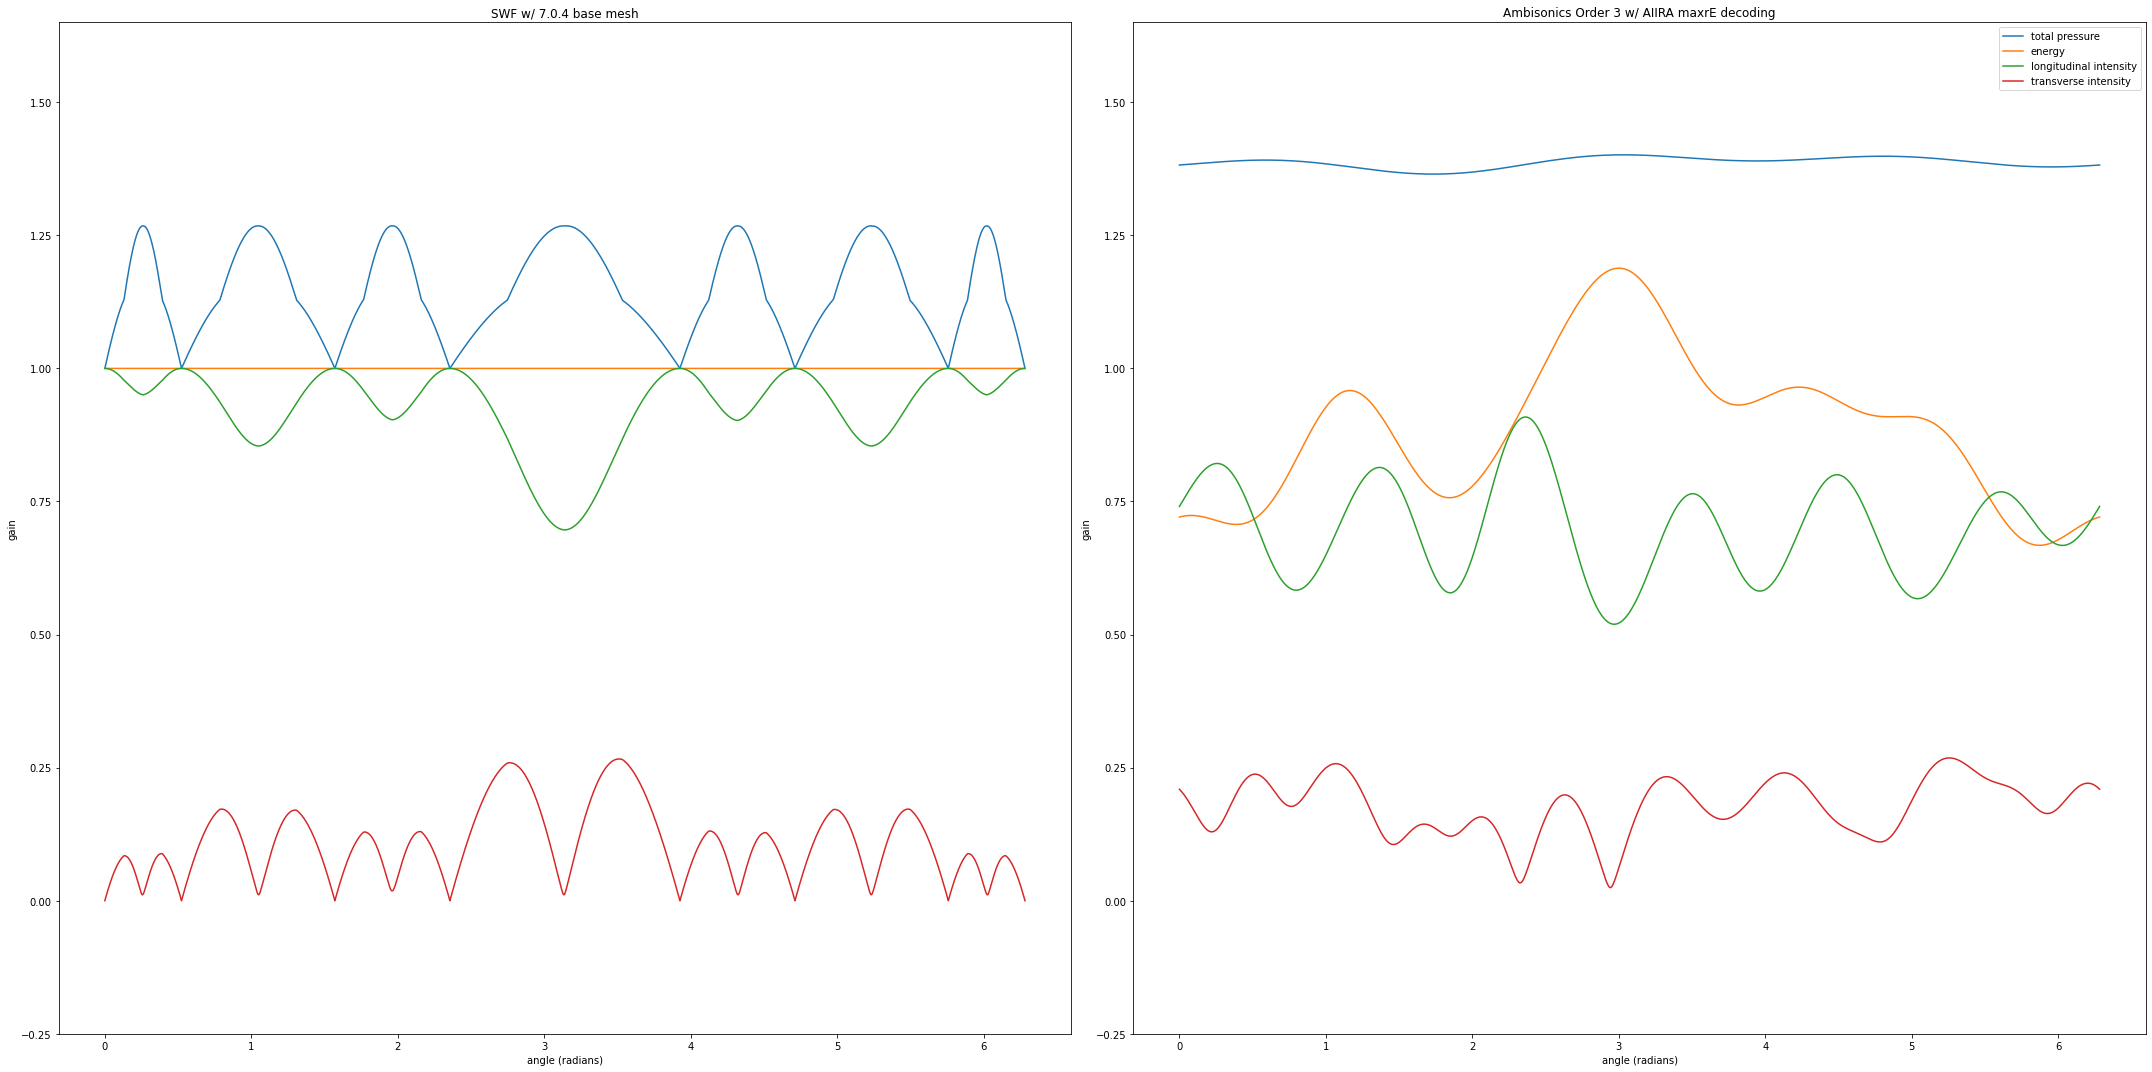

In [102]:
fig, subplots = plt.subplots(1,2,figsize=(30,15))
"""
for i in range(11):
    subplots[0,0].plot(theta,swf_encoded[:,i],label=f'channel {i}')
    subplots[0,1].plot(theta,ambi_decoded[:,i],label=f'channel {i}')
"""
subplots[0].plot(theta,pressureSWF,label='total pressure')
subplots[0].plot(theta,energySWF,label='energy')
subplots[0].plot(theta,intensitySWF[:,0],label='longitudinal intensity')
subplots[0].plot(theta,intensitySWF[:,1],label='transverse intensity')

subplots[1].plot(theta,pressureAMB,label='total pressure')
subplots[1].plot(theta,energyAMB,label='energy')
subplots[1].plot(theta,intensityAMB[:,0],label='longitudinal intensity')
subplots[1].plot(theta,intensityAMB[:,1],label='transverse intensity')

subplots[0].set_title('SWF w/ 7.0.4 base mesh')
subplots[1].set_title('Ambisonics Order 3 w/ AIIRA maxrE decoding')

for splt in subplots.flatten():
    splt.set_xlabel('angle (radians)')
    splt.set_ylabel('gain')
    splt.set_ylim(-0.25,1.65)

subplots[1].legend(loc=1)
fig.tight_layout()
plt.savefig('SWFvsAMB_unit_energy.png')

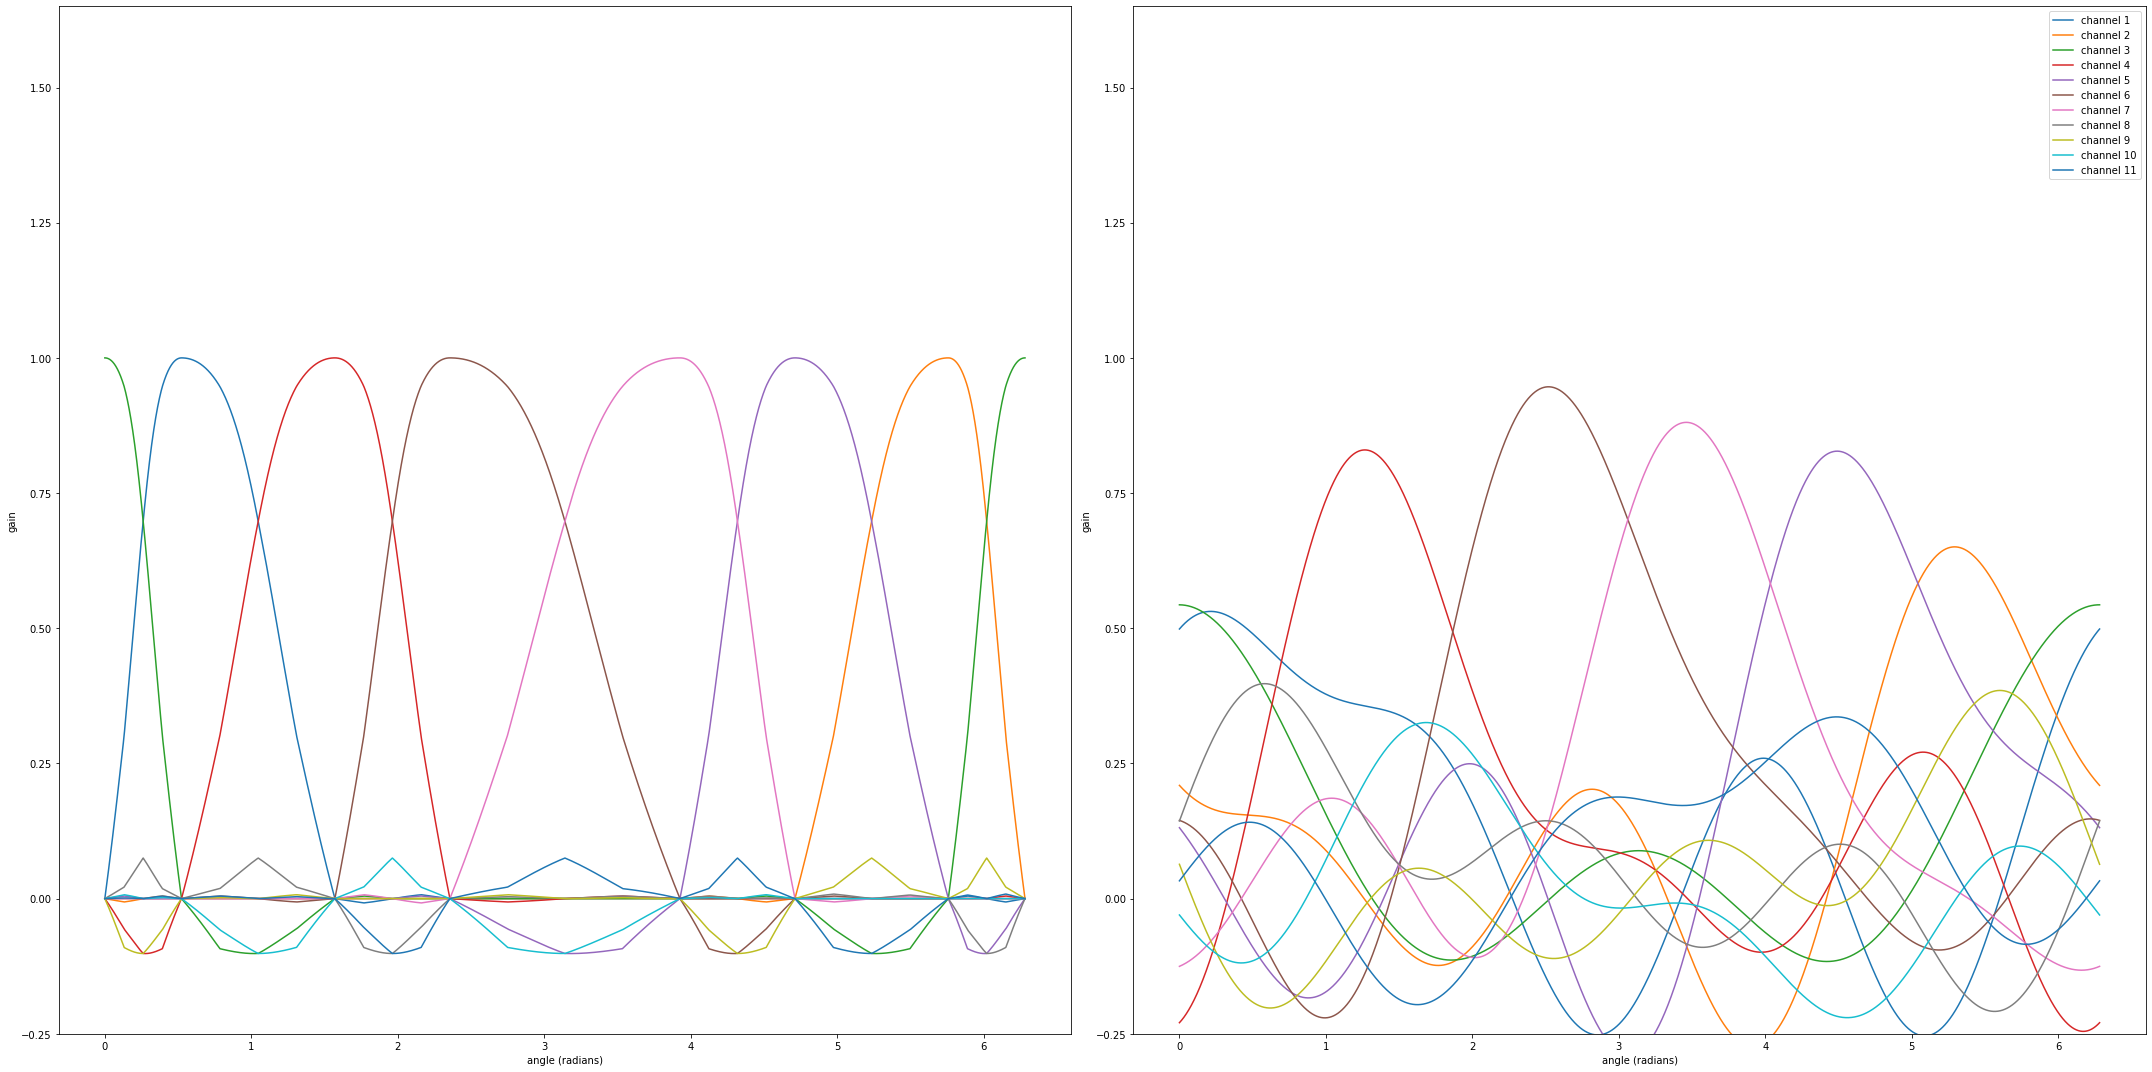

In [106]:
fig, subplots = plt.subplots(1,2,figsize=(30,15))

for i in range(11):
    subplots[0].plot(theta,swf_encoded[i],label=f'channel {i+1}')
    subplots[1].plot(theta,ambi_decoded[i],label=f'channel {i+1}')
for splt in subplots.flatten():
    splt.set_xlabel('angle (radians)')
    splt.set_ylabel('gain')
    splt.set_ylim(-0.25,1.65)

subplots[1].legend(loc=1)
fig.tight_layout()